In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display
import os

from sklearn.model_selection import train_test_split

In [3]:
path = "../Speech Emotion Recognition/AudioWAV/"
audio_path = []
audio_emotion = []

In [4]:
# collects all the audio filename in the variable 'path'
directory_path = os.listdir(path)

In [5]:
for audio in directory_path:
    audio_path.append(path + audio)
    emotion = audio.split('_')
    if emotion[2] == 'SAD':
        audio_emotion.append("sad")
    elif emotion[2] == 'ANG':
        audio_emotion.append("angry")
    elif emotion[2] == 'DIS':
        audio_emotion.append("disgust")
    elif emotion[2] == 'NEU':
        audio_emotion.append("neutral")
    elif emotion[2] == 'HAP':
        audio_emotion.append("happy")
    elif emotion[2] == 'FEA':
        audio_emotion.append("fear")
    else:
        audio_emotion.append("unknown")

In [6]:
emotion_dataset = pd.DataFrame(audio_emotion, columns=['Emotions'])
audio_path_dataset = pd.DataFrame(audio_path, columns=['Path'])
dataset = pd.concat([audio_path_dataset, emotion_dataset], axis= 1)
print(dataset.head())

                                                Path Emotions
0  ../Speech Emotion Recognition/AudioWAV/1001_DF...    angry
1  ../Speech Emotion Recognition/AudioWAV/1001_DF...  disgust
2  ../Speech Emotion Recognition/AudioWAV/1001_DF...     fear
3  ../Speech Emotion Recognition/AudioWAV/1001_DF...    happy
4  ../Speech Emotion Recognition/AudioWAV/1001_DF...  neutral


# Visualization

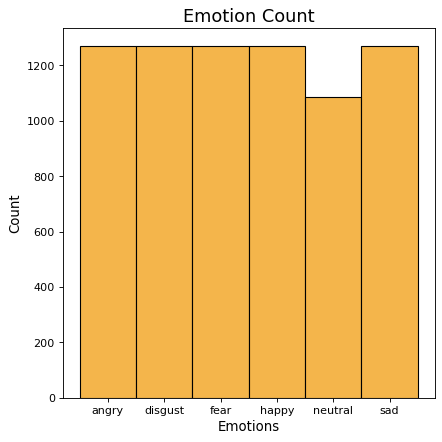

In [7]:
# counting audio categorized by emotions
plt.figure(figsize=(6, 6), dpi=80)
plt.title("Emotion Count", size=16)
plt.xlabel('Emotions', size=12)
plt.ylabel('Count', size=12)

# Define custom colors for each emotion
emotion_colors = {
    "sad": "#1f77b4",
    "angry": "#ff7f0e",
    "disgust": "#2ca02c",
    "neutral": "#d62728",
    "happy": "#9467bd",
    "fear": "#8c564b",
    "unknown": "#7f7f7f"
}

# Count emotions and plot histogram with data labels and colors
emotion_counts = dataset['Emotions'].value_counts()
ax = sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette=emotion_colors.values())
for p, label in zip(ax.patches, emotion_counts.values):
    ax.annotate(str(label), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()


# Showing spectrogram and waveplot

In [8]:
emotion_sad = dataset[dataset['Emotions']=='sad']['Path']
print(type(emotion_sad))

<class 'pandas.core.series.Series'>


In [9]:
#choosing a file to plot wave and spectogram
#print(emotion_sad.values[65])
data_path = emotion_sad.values[542]
data, sampling_rate = librosa.load(data_path)

# Waveplot

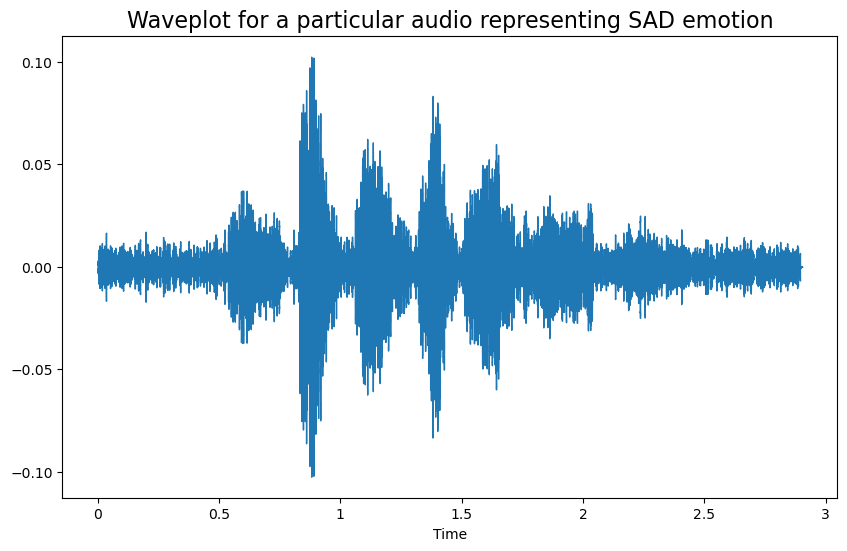

In [11]:
plt.figure(figsize=(10,6))
plt.title("Waveplot for a particular audio representing SAD emotion", size=16)
librosa.display.waveshow(data, sr=sampling_rate)
plt.show()

# Spectogram

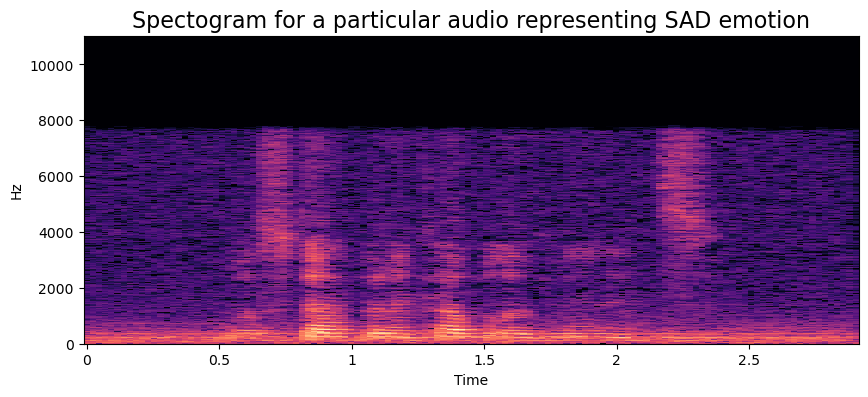

In [12]:
plt.figure(figsize=(10,4))
plt.title("Spectogram for a particular audio representing SAD emotion", size=16)
D = librosa.stft(data)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(S_db, sr = sampling_rate, x_axis='time', y_axis='hz')
#plt.show()

# Augmentation (Noise Injection)

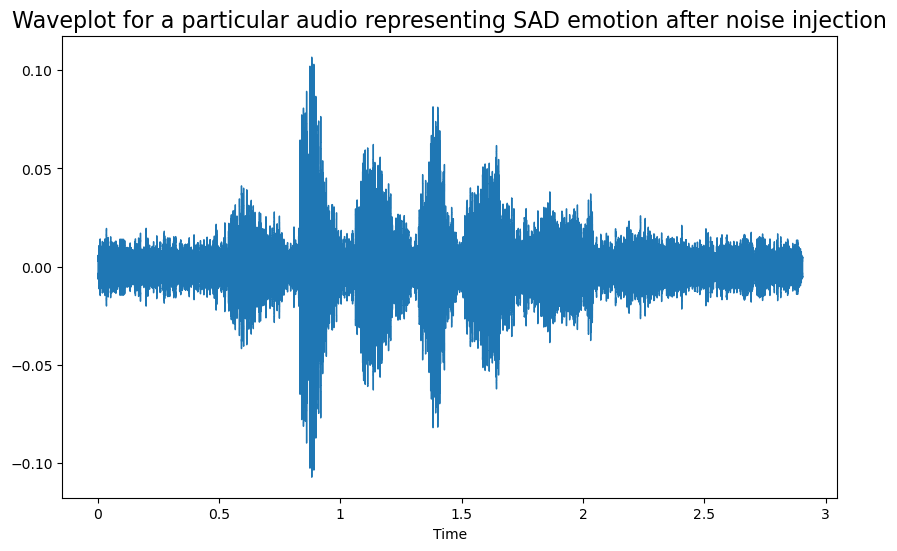

In [14]:
# for audio processing accuracy
# add noise to audio and check how the waveplot changes
# also the observing the change in audio quality

## Augmentation (Noise Injection)
noise_amp = 0.035*np.random.uniform()*np.amax(data)
audio_injected_data = data + noise_amp*np.random.normal(size=data.shape[0])

# waveplot view after noise injection:
plt.figure(figsize=(10,6))
plt.title("Waveplot for a particular audio representing SAD emotion after noise injection", size=16)
librosa.display.waveshow(audio_injected_data, sr=sampling_rate)
plt.show()

# Feature extraction

## Creating a DF with extracted Feautures

In [15]:
X, Y = [], []
print("Feature processing...")

for path, emo, index in zip(dataset.Path, dataset.Emotions, range(len(dataset))):
    value, sample = librosa.load(path)
    # noise injection
    noise_amp = 0.035 * np.random.uniform() * np.amax(value)
    value = value + noise_amp * np.random.normal(size=value.shape[0])
    # mfcc
    mfcc = librosa.feature.mfcc(y=value, sr= sample, n_mfcc=13, n_fft=200, hop_length=512)
    mfcc = np.ravel(mfcc.T)
    # mel
    mel = librosa.feature.melspectrogram(y=value, sr=sample, hop_length = 256, n_fft = 512, n_mels=64)
    mel = librosa.power_to_db(mel ** 2)
    mel = np.ravel(mel).T
    result = np.array([])
    result = np.hstack((result, mfcc, mel))
    #print(result)
    result = np.array(result)
    X.append(result)
    Y.append(emo)

Feature processing...


In [16]:
# print(X)
# print(Y)
extracted_audio_df = pd.DataFrame(X)
extracted_audio_df["emotion_of_audio"] = Y
print(extracted_audio_df.shape)
print(extracted_audio_df.tail(10))
extracted_audio_df = extracted_audio_df.fillna(0)
#print(extracted_audio_df.isna().any())

(7442, 30457)
               0          1          2          3          4          5  \
7432 -725.689722 -48.912731   8.057538  28.246017  14.455115 -14.116627   
7433 -773.379673  -5.166290  -2.482531  26.161520  11.781338 -10.980389   
7434 -694.702272 -64.183545 -11.758122   9.804456  17.622144 -13.020205   
7435 -812.958881 -12.840926 -14.167480  10.136079  10.566678   9.018344   
7436 -640.425357 -64.832150 -22.352300  -2.874462  21.697879  -8.504549   
7437 -733.941945 -89.803852  -8.755665  38.785947  28.477162   5.878375   
7438 -696.526163 -61.511340  -5.450574  22.415382   1.692612   0.124019   
7439 -665.950761 -75.121797 -13.163319  18.229145  14.486685   3.448126   
7440 -641.834931 -87.327545  -8.291966  18.133832   7.672173 -13.351382   
7441 -837.898252 -25.766677  20.465023  17.963511   5.199018  -8.217427   

              6          7          8          9  ...  30447  30448  30449  \
7432 -21.068532   2.155861  -1.698303  -4.608220  ...    NaN    NaN    NaN   
7433

# Training

In [17]:
# preparing to train
X = extracted_audio_df.drop(labels='emotion_of_audio', axis= 1)
Y = extracted_audio_df['emotion_of_audio']

x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.2)


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Model creation and fitting

In [19]:
mlp_model = MLPClassifier(activation='relu',
                         solver='sgd',
                         hidden_layer_sizes=100,
                         alpha=0.839903176695813,
                         batch_size=150,
                         learning_rate='adaptive',
                         max_iter=100000)
# Fit mlp model
mlp_model.fit(x_train,y_train)

MLPClassifier(alpha=0.839903176695813, batch_size=150, hidden_layer_sizes=100,
              learning_rate='adaptive', max_iter=100000, solver='sgd')

# Accuracy calculation

In [20]:
y_pred = mlp_model.predict(x_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# the accuracy didn't turn out to be that good :(
print("\nModel:{}    Accuracy: {:.2f}%".
          format(type(mlp_model).__name__ , accuracy*100))

# Print the classification report
classification_rep = classification_report(y_true=y_test, y_pred=y_pred, target_names=mlp_model.classes_)
print("Classification Report:")
print(classification_rep)


Model:MLPClassifier    Accuracy: 39.56%


# Prediction verification


In [21]:
# the prediction made by the model:
print("The Prediction Made By Model: ")
print("<<<===========================================>>>")
df = pd.DataFrame({'Actual': y_test, 'Predict': y_pred})
print(df.head())

The Prediction Made By Model: 
<<<===========================================>>>
       Actual  Predict
7109  disgust     fear
1060    angry    happy
3793    angry    angry
5828    happy    angry
956     happy  disgust
